In [ ]:
import os
import time
import PyPDF2
import nltk
import networkx as nx
import json
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_community.graphs.networkx_graph import NetworkxEntityGraph
from langchain.chains import GraphQAChain
from langchain.text_splitter import RecursiveCharacterTextSplitter


os.environ["OPENAI_API_KEY"] = "api-key"  # Replace with your OpenAI API key

# Initialize the LLM and Embedding Model
llm = ChatOpenAI(model="gpt-4o", temperature=0.3, max_tokens=4000)
embedding_model = OpenAIEmbeddings()

/home/Sheneeza.Chaudhary/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [10]:
def extract_text_from_pdf(file_path: str):
    """Extracts text from a PDF file."""
    with open(file_path, "rb") as file:
        pdf_reader = PyPDF2.PdfReader(file)
        text = "".join([page.extract_text() for page in pdf_reader.pages])
    return text

def split_into_chunks(text):
    """Splits text into chunks using RecursiveCharacterTextSplitter."""
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=400)
    chunks = text_splitter.split_text(text)
    return [Document(page_content=chunk) for chunk in chunks]

def compute_embeddings(documents):
    """Computes embeddings for document chunks."""
    document_texts = [doc.page_content for doc in documents]
    return embedding_model.embed_documents(document_texts)

In [11]:
def create_graph_from_documents(documents):
    """Creates a knowledge graph from document chunks using LLMGraphTransformer."""
    llm_transformer = LLMGraphTransformer(llm=llm)
    graph_documents = llm_transformer.convert_to_graph_documents(documents)

    # Create a NetworkX graph
    graph = NetworkxEntityGraph()
    for doc in graph_documents:
        for node in doc.nodes:
            graph.add_node(node.id)
        for edge in doc.relationships:
            graph._graph.add_edge(edge.source.id, edge.target.id, relation=edge.type)

    return graph, graph_documents


In [12]:
def get_reference_chunks_from_graph(question, graph_documents, document_chunks):
    """
    Simulates the retrieval of reference chunks from the graph based on the question.
    """
    reference_chunks = graph_documents[:10]  
    return reference_chunks

def extract_chunks_used_by_llm(question, documents, graph_documents):
    """
    Extracts the chunks used by the LLM from the retrieved graph documents.
    
    Args:
    - question (str): The query/question.
    - documents (list): List of original document chunks.
    - graph_documents (list): List of graph documents used for chunk retrieval.
    
    Returns:
    - List of original document chunks used by the LLM.
    """
    reference_chunks = get_reference_chunks_from_graph(question, graph_documents, documents)

    return reference_chunks

def query_llm(question):
    """Queries the LLM and returns the response along with the response time."""
    start_time = time.time()
    response = llm.invoke(question)  
    response_time = time.time() - start_time
    return response.content if hasattr(response, 'content') else "No answer generated.", response_time


In [13]:
def evaluate_response(reference_text, generated):
    """Evaluates the response using BLEU, ROUGE, METEOR, and Exact Match."""
    ref_tokens = reference_text.lower().split()
    gen_tokens = generated.lower().split()

    # BLEU Score
    smoothing = SmoothingFunction().method1
    bleu = sentence_bleu([ref_tokens], gen_tokens, smoothing_function=smoothing)
    
    # ROUGE Score
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge.score(reference_text, generated) 

    # METEOR Score
    meteor = meteor_score([ref_tokens], gen_tokens)

    # Exact Match (EM)
    exact_match = 1.0 if reference_text.strip().lower() == generated.strip().lower() else 0.0
    
    return bleu, rouge_scores, meteor, exact_match

In [14]:
def visualize_graph(graph):
    """
    Visualizes the NetworkX graph created from document chunks.
    """
    # Extract NetworkX graph from the entity graph
    nx_graph = graph._graph  

    # Define the position layout for the nodes in the graph
    pos = nx.spring_layout(nx_graph, seed=42)  

    # Draw the nodes and edges of the graph
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(nx_graph, pos, node_size=500, node_color="lightblue", alpha=0.6)
    nx.draw_networkx_edges(nx_graph, pos, edge_color="gray", width=2, alpha=0.6)
    nx.draw_networkx_labels(nx_graph, pos, font_size=10, font_family="sans-serif")

    # Display the graph
    plt.title("Document Knowledge Graph", size=15)
    plt.axis("off")  
    plt.show()

Please provide the path to the PDF file: ../cinderella.pdf
Extracting text from PDF...
Splitting text into chunks...
Computing embeddings...
Creating graph from documents...


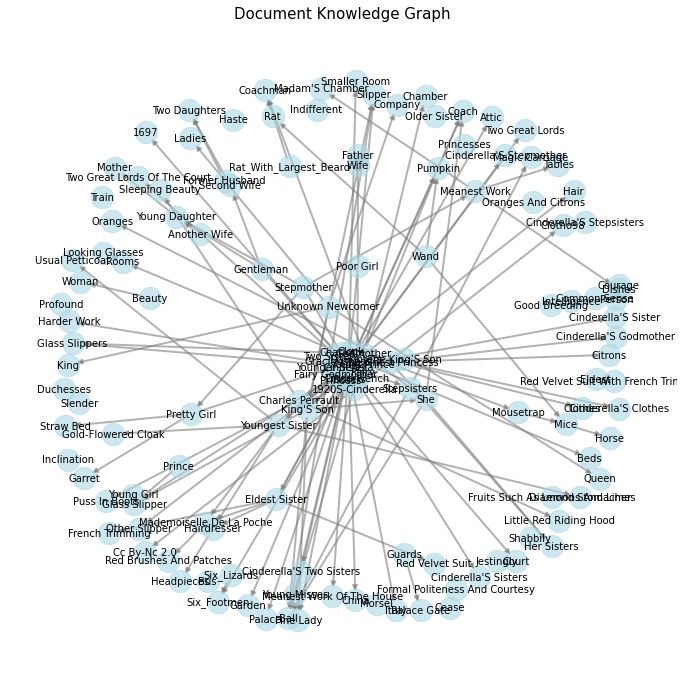

✅ Setup complete!


In [15]:
def setup():
    """Initial setup: processes PDF, creates graph, and precomputes embeddings."""
    file_path = input("Please provide the path to the PDF file: ")
    
    print("Extracting text from PDF...")
    extracted_text = extract_text_from_pdf(file_path)

    print("Splitting text into chunks...")
    document_chunks = split_into_chunks(extracted_text)

    print("Computing embeddings...")
    document_embeddings = compute_embeddings(document_chunks)

    print("Creating graph from documents...")
    graph, graph_documents = create_graph_from_documents(document_chunks)

    visualize_graph(graph)
    
    print("✅ Setup complete!")
    return graph, document_chunks, graph_documents

graph, document_chunks, graph_documents = setup()

In [16]:
# Initialize GraphQAChain
chain = GraphQAChain.from_llm(llm=llm, graph=graph, verbose=True)

In [17]:
import re

def extract_page_content_from_chunk(chunk_str):
    """
    Extracts the page content from a reference chunk string.
    """
    pattern = r"page_content='(.*?)'"
    match = re.search(pattern, chunk_str, re.DOTALL)
    if match:
        return match.group(1)
    return None

In [19]:
def interactive_question_prompt():
    while True:
        question = input("\nPlease enter a question (or type 'exit' to quit): ")
        if question.lower() == 'exit':
            print("Exiting...")
            break

        reference_chunks = get_reference_chunks_from_graph(question, graph_documents, document_chunks)
        
        extracted_contents = []
        for idx, chunk in enumerate(reference_chunks):
            chunk_str = str(chunk)
            content = extract_page_content_from_chunk(chunk_str)
            if content:
                extracted_contents.append(content)
            else:
                extracted_contents.append("No page content found.")

        reference_text = " ".join(extracted_contents)
        answer = chain.run(question)
        print("\n💡 Answer from LLM:", answer)
        bleu, rouge_scores, meteor, exact_match = evaluate_response(reference_text, answer)
        print("\n📊 Evaluation Metrics:")
        print(f"🔹 BLEU Score: {bleu:.4f}")
        print(f"🔹 ROUGE Scores: {rouge_scores}")
        print(f"🔹 METEOR Score: {meteor:.4f}")
        print(f"🔹 Exact Match: {exact_match}")

interactive_question_prompt()



Please enter a question (or type 'exit' to quit): who does cinderella live with


> Entering new GraphQAChain chain...
Entities Extracted:
Cinderella
Full Context:
Cinderella AUTHOR Charles Perrault
Cinderella PUBLISHED 1697
Cinderella HAS_ROOTS China
Cinderella HAS_ROOTS Italy
Cinderella BRING Pumpkin
Cinderella FEATURES Fairy Godmother
Cinderella FEATURES Glass Slippers
Cinderella GAVE_PART_OF Sisters
Cinderella PLEATED_RUFFLES Eldest Sister
Cinderella PLEATED_RUFFLES Youngest Sister
Cinderella FIX Hair
Cinderella ATTEND Ball
Cinderella TOLD Godmother
Cinderella WANTS_TO_GO Court
Cinderella WENT_TO Garden
Cinderella ENTER Coach
Cinderella COMPANIONSHIP King'S Son
Cinderella ASKED_NAME The Finest Princess
Cinderella ASKED_FOR_DRESS Charlotte
Cinderella SIBLING Cinderella'S Sister
Cinderella LEFT_BEHIND Glass Slipper
Cinderella ASKED_ABOUT Fine Lady
Cinderella SIBLING Two Sisters
Cinderella TRY Slipper
Cinderella POSSESS Other Slipper
Cinderella HAS_GODMOTHER Cinderella'S Godmother
Ci